# Qiskit en Python

<img src="img/qiskit_circ.png" width="700">

Es un kit de desarrollo de software para trabajar con computadoras cuánticas a nivel de circuitos. Proporciona herramientas para crear y manipular programas cuánticos y ejecutarlos en dispositivos cuánticos prototipo en IBM Quantum Experience o en simuladores localmente (Qiskit Aer). 

Adicionalmente, Qiskit brinda la capacidad de programar software tanto a nivel de máquina (mediante OpenQASM) o a nivel abstracto (mediante Python).

## Componentes Qiskit (Terra, Aer, Ignis -> Experiments)

**Terra:** Es la base de códigos o comandos que nos permite, en términos de compuertas cuánticas explícitamente, crear esquemas de circuitos cuánticos para posterior, transpilarse en un lenguaje para hardware cuántico (de forma local ó remota). **Por ejemplo:**

In [1]:
from qiskit import QuantumCircuit

circuito = QuantumCircuit(1,1) #El primer argumento N°Qúbits, El segundo N°BitsClásicos (Bits)
circuito.h(0) #Hadamard en Qúbit ubicado en índice 0

#Aplicar operación de medida
circuito.measure(0,0) #Mide el qúbit en la posición 0, y lo coloca en un bit clásico en la posición 0
circuito.draw()

#QuantumCircuit?
#Cbit -> Classical Bit

┌───┐┌─┐
  q: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

**Aer**: proporciona simuladores de computación cuántica alojados localmente **en el dispositivo del usuario**. Los simuladores interpretan los circuitos cuánticos creados con Terra. 

Adicionalmente, los simuladores también pueden simular los efectos del ruido para modelos de ruido simples y sofisticados.

**Por ejemplo:**

In [2]:
from qiskit import Aer, execute

simulador = Aer.get_backend("qasm_simulator")
proceso = execute(circuito, simulador, shots=500) #realiza transpile() y assemble() del circuito bajo la cubierta
resultado = proceso.result()

#resultado
resultado.get_counts(circuito)  #Obtiene los datos del histograma de un experimento.

{'1': 246, '0': 254}

El resultado es un diccionario de Python que describe las cadenas de bits obtenidas de 500 ejecuciones del circuito cuántico. Las cadenas de bits '1' y '0' deberían ser los únicos resultados posibles y deberían producirse con la misma probabilidad. 

**Ignis:** El elemento Ignis proporciona herramientas para la verificación de hardware cuántico, la caracterización de ruido y la corrección de errores. Su desarrollo ha cesado y ha sido eliminado en las versiones más nuevas de qiskit (la más reciente Qiskit v0.37.0), siendo remplazado por **"Qiskit Experiments"**.

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$

# Teleportación Cuántica con Qiskit

Transmitir información cuántica *sin enviar físicamente un qubit*.

**Por ejemplo:** Alice quiere enviar información cuántica a Bob. Suponga que quiere enviar específicamente el estado:

$$\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$$

Donde el ket $\ket{\psi}$ representa el estado arbitrario del qúbit de Alice que contiene la información ($\alpha$ y $\beta$) que se quiere enviar.

Debido al teorema de no clonación de la mecánica cuántica, Alice no puede simplemente hacer una copia de su qúbit en el estado $\ket{\psi}$ y dársela a Bob. 

> _Sólo podemos copiar estados clásicos (no superposiciones)._

Sin embargo, mediante dos bits clásicos y un par de qúbits entrelazados _adicionales_, Alice puede enviar la información de su qúbit (que denotaremos $q_0$ de aquí en adelante) en el estado $\ket{\psi}$ a Bob. Al final, Bob tendrá el estado de Alice $\ket{\psi}$ y Alice ya no lo tendrá. Esto es la teleportación cuántica.

## Protocolo de Teleportación

Para transferir la información de un qúbit:
1. Alice y Bob deben recurrir a un tercero _(Telamon)_ para que les envíe un par de qúbits entrelazados. 
2. Alice realiza entonces algunas operaciones en sus qúbits.
4. Alice envía los resultados a Bob a través de un canal de comunicación clásico (Whatsapp)
5. Bob realiza mediante los bits clásicos recibidos algunas operaciones en su extremo para recibir la información del qúbit de Alice.

<img src="img/tele1.jpg" width="700">

(**No olvidemos reiniciar el kernel aquí**)

## Algoritmo de Teleportación 

¡Vamos a convertir todo esto a código!
> Significa que, en principio, usaremos Python para crear el esquema del circuito de teleportación y simular su ejecución. Sin embargo, debe posteriormente convertirse a código de máquina cuántica para ser ejecutado (aunque en principio, este protocolo requiere de dos partes)

### Paso 0: Librerías Cuánticas de Python

In [3]:
# Importamos algunas cosas necesarias
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.result import marginal_counts

### Paso 1: Construir la base del Circuito

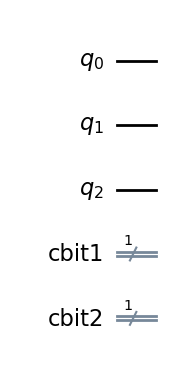

In [4]:
# El protocolo requiere 3 qúbits, y requiere 2 bits clásicos en diferentes registros.

qubits = QuantumRegister(3, name="q")    # Registramos 3 qúbits de nombre "q"
cbit1 = ClassicalRegister(1, name="cbit1") # Primer bit clásico 
cbit2 = ClassicalRegister(1, name="cbit2") # Segundo bit clásico
circuito = QuantumCircuit(qubits, cbit1, cbit2)

circuito.draw(output='mpl')
#pip install pylatexenc

#Si cbits estuvieran en un mismo registro, 
#sería una sola cadena de bits en la que se almacena la medida de un único qúbit

#Cbits separados en registros diferentes me asegura que un solo bit le corresponde a cada medida de un qúbit.

Recordemos que el qúbit $q_0$ es el qúbit que Alice desea enviar a Bob. 

### Paso 2: Entrelazamiento de Qúbits 
Ahora el Telamon, agarra los qúbits $q_1$ y $q_2$ y los entrelaza creando un par especial llamado par de Bell o Estado de Bell. 

In [5]:
#Función generadora de pares de Bell que recibe como argumento un circuito y dos qúbits
def crear_estado_de_bell(circuito, qubit1, qubit2):
    circuito.h(qubit1) # Puerta hadamard
    circuito.cx(qubit1, qubit2) # cx(control, objetivo) Puerta CNOT

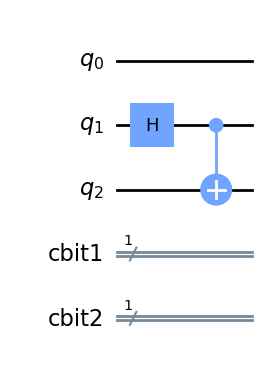

In [6]:
crear_estado_de_bell(circuito, qubits[1], qubits[2])
circuito.draw(output='mpl')

Teniendo el par de qúbits entrelazados, Alice se separa de Bob, y se lleva consigo el qúbit $q_1$, mientras que Bob se lleva el qúbit $q_2$.

### Paso 3: Operaciones locales en Qúbits (Alice)

Ahora Alice codificará la información de su qúbit $q_0$ en el qúbit entrelazado $q_1$. Para esto:
- Alice aplica una puerta CNOT sobre $q_1$ y controlada por $q_0$ (con el estado $\ket{\psi}$).
- Luego Alice aplica una puerta Hadamard sobre $q_0$.

In [7]:
def alice_operaciones(circuito, qubit0, qubit1):
    circuito.cx(qubit0, qubit1)
    circuito.h(qubit0)

In [8]:
circuito.barrier() #Genera una barra que separa visualmente el paso 2 del paso 3
alice_operaciones(circuito, qubits[0], qubits[1])

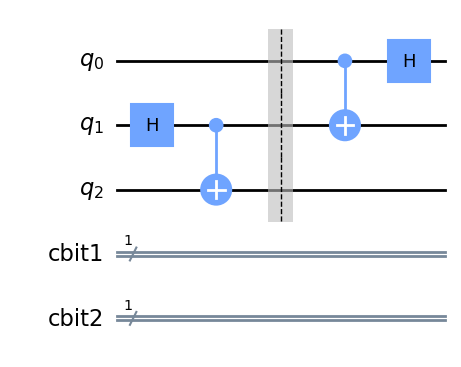

In [9]:
circuito.draw(output="mpl")

### Paso 4: Medida de Qúbits en Bits Clásicos

Ahora Alice realiza la operación de medida sobre los qúbits que posee, es decir, sobre $q_0$ y $q_1$. Los resultados que obtiene los almacena en dos bits clásicos. Estos bits clásicos serán posteriormente enviados por Alice mediante Whatsapp a Bob.

In [10]:
def medir_luego_enviar(circuito, qubit0, qubit1, bit1, bit2):
    #Se miden los qúbits q0 y q1 y se "envían" los resultados a Bob por whatsapp
    circuito.measure(qubit0, bit1)
    circuito.measure(qubit1, bit2)

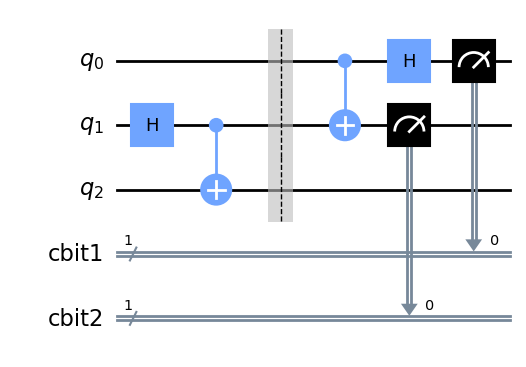

In [11]:
medir_luego_enviar(circuito, qubits[0], qubits[1], cbit1, cbit2)
circuito.draw(output="mpl")

### Paso 5: Operaciones locales en Qúbits (Bob)

Bob, ya posee el qúbit $q_2$, aplicará las siguientes puertas sobre dicho qúbit dependiendo del estado de los bits clásicos que recibió por Whatsapp:

- Si Bob recibe: $(0, 0) \rightarrow$ él no hace nada.
- Si Bob recibe: $(1, 0) \rightarrow$ él aplica la puerta $\mathbf{Z}$.
- Si Bob recibe: $(0, 1) \rightarrow$ él aplica la puerta $\mathbf{X}$.
- Si Bob recibe: $(1, 1) \rightarrow$ él aplica las puertas $\mathbf{ZX}$ (primero $\mathbf{X}$ y luego $\mathbf{Z}$).

Recuerde que el orden de los bits es: $(cbit_2, cbit_1)$

* $cbit_2$ (el de la izquierda) al medir $q_1$
* $cbit_1$ (el de la derecha) al medir $q_0$.

In [12]:
# Esta función toma el circuito, los qúbits y los bits clásicos para decidir qué puertas aplicar
# c_if(cbit, val) Establece una condición de igualdad clásica entre el cbit clásico y el valor val.

def bob_operaciones(circuito, qubits, bit1, bit2):
    # Utilizamos c_if para controlar nuestras puertas con un bit clásico en vez de un qúbit
    circuito.x(qubits[2]).c_if(bit2, 1) #El cbit2 es resultado de medir q1
    circuito.z(qubits[2]).c_if(bit1, 1) #El cbit1 es resultado de medir q0
    #Se aplicarán las puertas X ó Z si los bit0 ó bit1 se encuentran en el estado 1.
    
def bob_operaciones_IBMQ(circuito, qubits): #Principio de mediciòn diferida
    #Esta parte se revisará al final del notebook
    circuito.cx(qubits[1], qubits[2])
    circuito.cz(qubits[0], qubits[2]) 

In [13]:
circuito.barrier()
bob_operaciones(circuito, qubits, cbit1, cbit2)

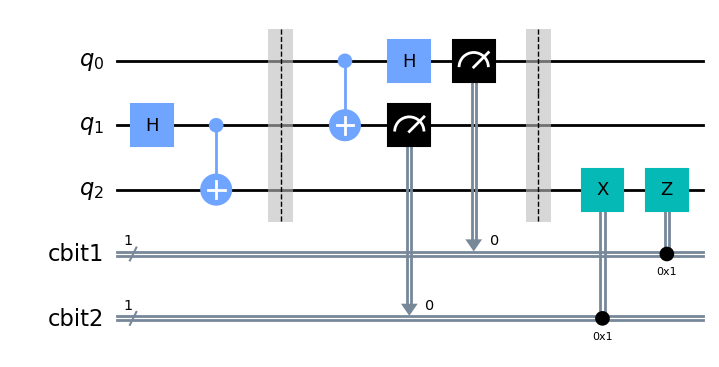

In [14]:
circuito.draw(output="mpl")

## Protocolo de Teleportación con $\alpha$ y $\beta$ Definidos

Anteriormente definimos el estado del qúbit $q_0$ como: $\ket{\psi} = \alpha \ket{0}+\beta \ket{1}$. Pero no definimos el valor de los amplitudes de probabilidad $\alpha$ y $\beta$, que son necesarios para efectuar la simulación ya que por defecto, qiskit asume que el estado inicial de $q_0$ es: $\ket{\psi} = \ket{0}$ 

### Definir Vector de Estado con Statevector()

In [15]:
psi0 = Statevector(np.array([1,1])) #la suma de amplitudes al cuadrado no es uno
psi0.draw('latex')

<IPython.core.display.Latex object>

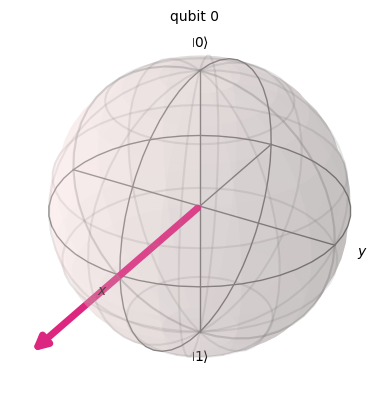

In [16]:
plot_bloch_multivector(psi0)

In [17]:
psi = Statevector(random_statevector(2)) #random_statevector(dimension)
psi.draw('latex')

<IPython.core.display.Latex object>

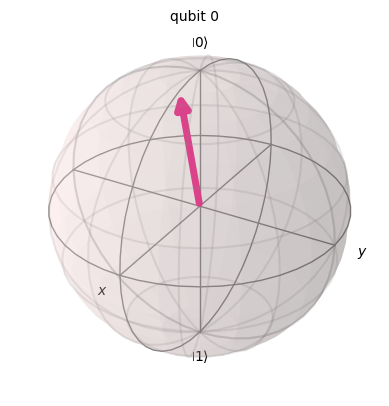

In [18]:
plot_bloch_multivector(psi)

### Inicializar estado de un Qúbit con Initialize()

Ahora podemos usar el método Initialize(Statevector) como una operación para transformar el estado inicial de un qúbit (el de Alice) en cualquier otro estado (en el estado $\ket{\psi}$).

Initialize() técnicamente no es una puerta (aunque el circuito diga lo contrario), ya que Initialize() contiene una operación que resetea el qúbit, por lo que no es una operación unitaria.  (Lo llamamos una 'instrucción' de inicio sobre el qúbit en su lugar). 

In [19]:
gate = Initialize(psi) #Crea una operación de inicialización basada en un vector de estado psi.
#Alice prepara su estado.

**Por ejemplo:**

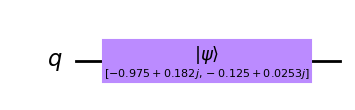

In [20]:
circuito0 = QuantumCircuit(1)

#Inicializamos el qúbit de Alice:
circuito0.append(gate, [0])
#circuito.append(operacion, lista_de_qubits). Agrega la instrucción "gate" al final del circuito. 

circuito0.draw(output="mpl")

## Función de Teleportación

In [21]:
def teleportation(psi, inverse_transform, real_hardware):
    #Preparamos el qúbit de Alice, y además definimos la operación inversa para el qúbit de Bob 
    #a partir de la operación inicial
    q0_init_transform = Initialize(psi)
    q2_reverse_transform = q0_init_transform.gates_to_uncompute()
    
    qubits = QuantumRegister(3, name="q")    # Registramos 3 qúbits de nombre "q"
    
    if real_hardware == False:
        cbit1 = ClassicalRegister(1, name="cbit1") # Primer bit clásico 
        cbit2 = ClassicalRegister(1, name="cbit2") # Segundo bit clásico
        circuito = QuantumCircuit(qubits, cbit1, cbit2)

        #Inicializamos el qúbit de Alice:
        circuito.append(q0_init_transform, [0]) #agrega la instrucción "q0_init_transform" al final del circuito 
        circuito.barrier()
    
        #El Telamon crea un par de Bell
        crear_estado_de_bell(circuito, qubits[1], qubits[2])
        circuito.barrier()
    
        #Alice realiza operaciones con sus qubits
        alice_operaciones(circuito, qubits[0], qubits[1])
        #circuito.save_statevector()
    
        #Alice mide sus qúbits y envía por whatsapp a Bob
        medir_luego_enviar(circuito, qubits[0], qubits[1], cbit1, cbit2)
        circuito.barrier()
    
        #Bob recibe bits de Alice y efectúa algunas operaciones
        bob_operaciones(circuito, qubits, cbit1, cbit2)
        
        # Aplicamos la "operación inversa sobre q2 (el qubit de Bob)"
        # la variable inverse_transform verifica si debemos o no aplicar la operación inversa sobre q2
        if inverse_transform: 
            circuito.append(q2_reverse_transform, [2])
        
    else:
        bit_IBMQ = ClassicalRegister(1, name="cb")
        circuito = QuantumCircuit(qubits, bit_IBMQ)
        circuito.append(q0_init_transform, [0])
        crear_estado_de_bell(circuito, qubits[1], qubits[2])
        alice_operaciones(circuito, qubits[0], qubits[1])
        bob_operaciones_IBMQ(circuito, qubits)
        if inverse_transform: circuito.append(q2_reverse_transform, [2])
        circuito.measure(qubits[2], bit_IBMQ)
    
    return [circuito, qubits]

Si el circuito funciona, al final de éste, el estado del qúbit $q_2$ de Bob que llamaremos $\ket{q_2}$, coincidirá con el estado $\ket{\psi}$ de Alice.

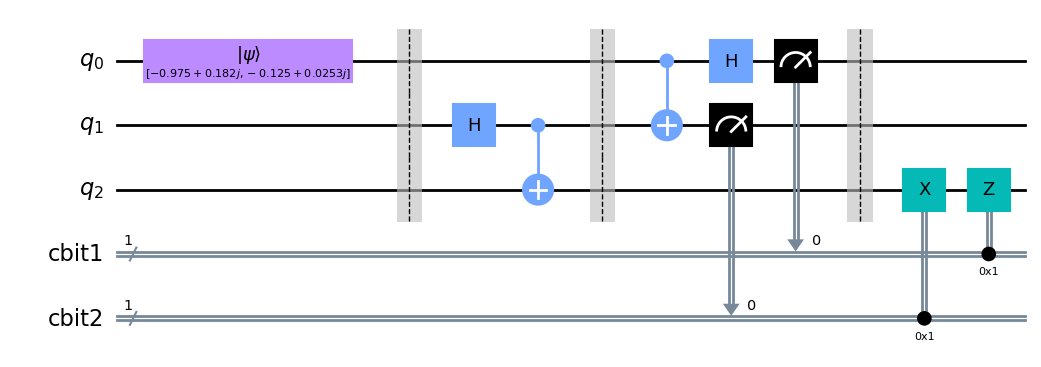

In [22]:
qc, qubits = teleportation(psi, inverse_transform=False, real_hardware=False)
qc.draw(output="mpl")

### ¿Cómo obtener vectores de estado al final del circuito?

El método save_statevector() guarda el estado cuántico actual de todos los qúbits del simulador como un vector de estado múltiple como una instrucción adjunta al objeto qc. 

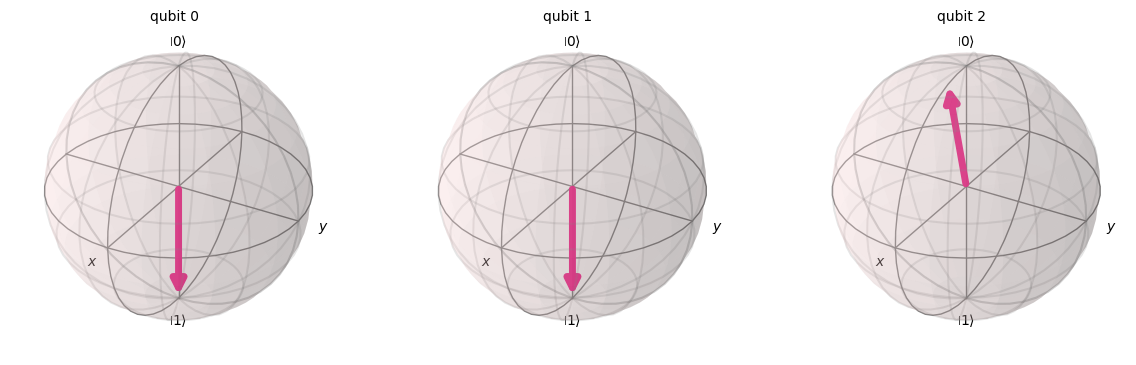

In [23]:
sim = Aer.get_backend("aer_simulator") 
qc.save_statevector() 

#Ejecutamos el circuito en el simulador y accedemos a los resultados, específicamente
#accedemos a los vectores de estado
out = execute(qc, sim).result().get_statevector()
plot_bloch_multivector(out)

## Conteo por Simulación

Hasta el momento hemos trabajado con el simulador qiskit que nos permite hacer algunas acciones que no podríamos hacer en hardware cuántico real. En un ordenador cuántico real, no podríamos muestrear el vector de estado, así que si queremos comprobar que nuestro circuito de teletransporte funciona, tenemos que hacer las cosas de forma ligeramente diferente.

La instrucción Initialize primero realiza un reset, poniendo nuestro qubit en el estado $\ket{0}$. Luego, aplica una "Puerta" para: $$\ket{0} \xrightarrow{\text{Puerta Initialize}} \ket{\psi}$$

Como todas las puertas cuánticas deben ser reversibles, podemos encontrar la inversa de estas puertas:
$$\ket{\psi} \xrightarrow{\text{Puerta Initialize Inversa}} \ket{0}$$

In [24]:
qc2, qubits2 = teleportation(psi, inverse_transform=False, real_hardware=False) #Aplicamos transfomaciòn inversa

Para probar que el estado $\ket{\psi}$ de $q_0$ se ha teleportado al qúbit $q_2$, aplicamos la operación inversa a la operación de inicialización sobre el qúbit $q_2$, esperando medir $\ket{0}$ con certeza en el qúbit de Bob, ya que el estado previo a la preparación del qúbit de Alice es justamente el estado $\ket{0}$.

Tendremos que almacenar la medida de $q_2$ en un nuevo bit clásico. Agreguemos esta instrucción al esquema del circuito:

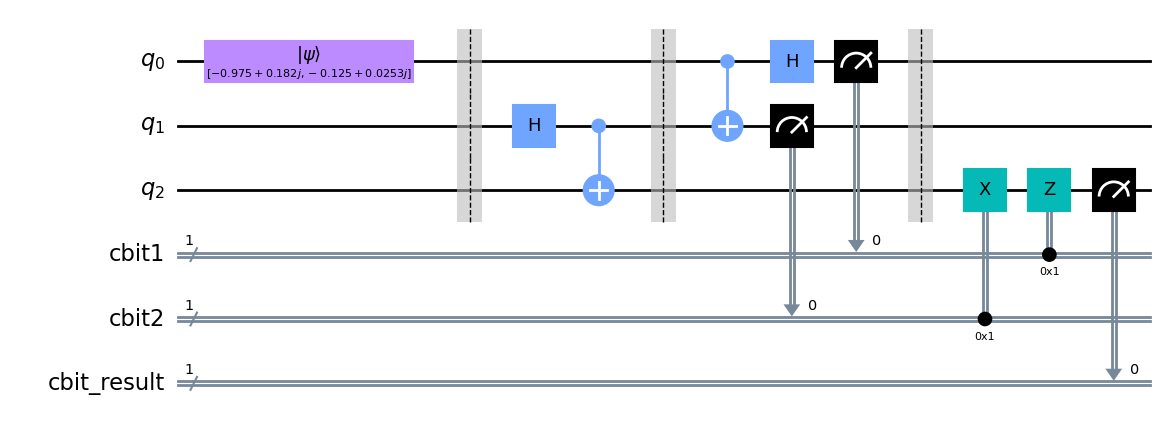

In [25]:
cbit_result = ClassicalRegister(1, name="cbit_result")
qc2.add_register(cbit_result)
qc2.measure(2, cbit_result)
qc2.draw(output="mpl", filename="teleportacion.png")

In [26]:
output = execute(qc2, sim, shots=20000)
counts = output.result().get_counts()

In [27]:
counts #Este resultado no es legible

{'1 1 0': 88,
 '1 0 1': 99,
 '1 0 0': 76,
 '0 1 0': 4922,
 '0 0 0': 4916,
 '1 1 1': 85,
 '0 1 1': 4916,
 '0 0 1': 4898}

Es aconsejable usar marginal_counts() para marginar la cuenta de un experimento según el qúbit y según el estado de la medida de cada qúbit (es decir, el bit clásico). **Por ejemplo: para el qúbit de Bob,**

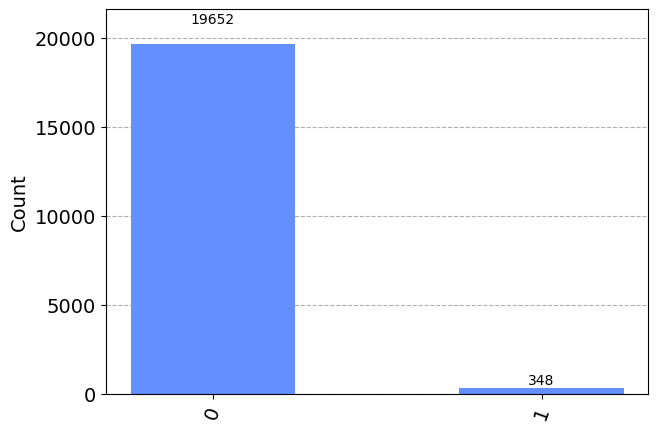

In [28]:
qubit_bob_count = marginal_counts(counts, [2])
plot_histogram(qubit_bob_count)

Ahora marginemos para los 3 qúbits del experimento y graficamos un histograma: 

In [29]:
qubit_counts = [marginal_counts(counts, [qubits2]) for qubits2 in range(3)] #Esta instrucción margina la cuenta
print(qubit_counts)

[{'0': 10002, '1': 9998}, {'1': 10011, '0': 9989}, {'1': 348, '0': 19652}]


In [41]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Estados Clásicos')

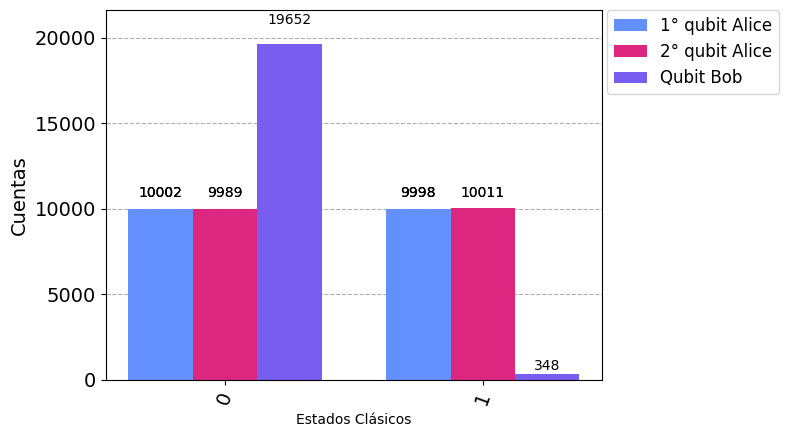

In [45]:
grafica = plt.subplot()
legendas = ["1° qubit Alice","2° qubit Alice","Qubit Bob"]
plot_histogram(qubit_counts, ax=grafica, legend=legendas)
grafica.set_ylabel('Cuentas')
grafica.set_xlabel('Estados Clásicos')

Vemos que el qúbit de Bob $q_2$ tiene probabilidad absoluta de encontrarse en el estado $\ket{0}$ (barra azul fuerte). La probabilidad del qúbit $q_1$ es la barra morada y del qúbit $q_0$ la barra azul claro.

## Teleportación Cuántica en un Ordenador Cúantico **Real**

### Principio de Medición Diferida

Los ordenadores cuánticos de IBM no admiten actualmente instrucciones después de las mediciones, lo que significa que no podemos ejecutar el esquema que tenemos de teleportación cuántica a partir del **PASO 5, Operaciones de Bob** en hardware real. 

Afortunadamente, esto no limita la capacidad de demostrar el circuito de teleportación gracias a el **"principio de medición diferida"** (consulte en el textbook de Qiskit). 

> Este principio establece que cualquier medición puede posponerse hasta el final del circuito, es decir, podemos trasladar todas las operaciones de medida al final, y deberíamos ver los mismos resultados. (Observe el esquema a continuación)

<img src="img/defer_measurement.svg" width="600">

En vez de medir y en función del bit clásico aplicar la puerta $\mathbf{Z}$, podemos sustituirlas por una puerta C-Z (Controlled Z) y al final realizamos la medida sobre el qúbit correspondiente.

> Tenga en cuenta que aunque el desplazamiento de las operaciones de medida nos permite demostrar el circuito de "teletransporte" en hardware real, hay que tener en cuenta que el beneficio del proceso de teletransporte (la transferencia de estados cuánticos) se pierde.

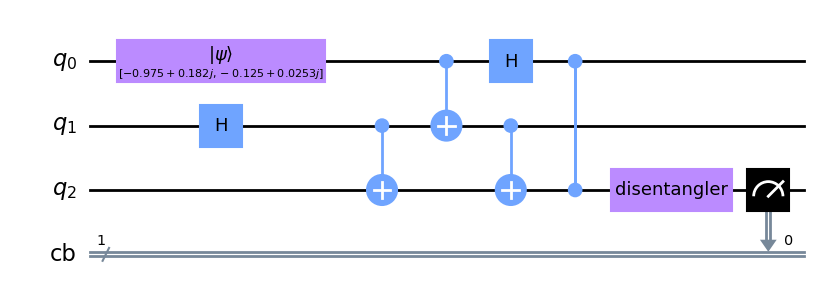

In [31]:
qc_IBM, qubits_IBM = teleportation(psi, inverse_transform=True, real_hardware=True)
qc_IBM.draw(output="mpl")

### Ejecución

Necesitaremos conexión a internet, una cuenta en https://quantum-computing.ibm.com/ y generar un TOKEN desde el sitio web. A continuación, seguimos los pasos:

### PASO 1: Generar Token y Habilitar la cuenta

El token se genera en el sitio web de IBMQ. Es único según la cuenta del usuario:

<img src="IBM_TOKEN.jpg" width="700">

In [32]:
token = "58951455539373d2e8279b36a34db2b7e59874c708478e433fd88c1633415b6e0cae9a12604bad1d9a79aa33b0cc4adf57f25c68f445c6ece5e2bf9b12e8ed86"
#Este Token es de ejemplo. Utilice el suyo.
IBMQ.enable_account(token)

/tmp/ipykernel_14557/2274679754.py:3: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.enable_account(token)
/tmp/ipykernel_14557/2274679754.py:3: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.enable_account(token)


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

**Si usted desea guardar la sesión en su disco duro:**
Guarde su cuenta en su disco duro para utilizarla en el futuro.

In [33]:
IBMQ.save_account(token)

configrc.store_credentials:WARNING:2023-05-09 19:57:10,802: Credentials already present. Set overwrite=True to overwrite.


Podemos revisar las sesiones almacenadas en el disco mediante:

In [34]:
IBMQ.stored_account()

{'token': '58951455539373d2e8279b36a34db2b7e59874c708478e433fd88c1633415b6e0cae9a12604bad1d9a79aa33b0cc4adf57f25c68f445c6ece5e2bf9b12e8ed86',
 'url': 'https://auth.quantum-computing.ibm.com/api'}

### PASO 3: Cargar la cuenta

In [35]:
# Primero, veamos qué ordenadores podemos utilizar según nuestra cuenta de IBM
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q') #En un futuro se estudiará el proveedor

ibmqfactory.load_account:WARNING:2023-05-09 19:57:11,215: Credentials are already in use. The existing account in the session will be replaced.


### PASO 4: Localizar el Ordenador Cuántico

Consigamos el backend menos ocupado en IBM y ejecutemos el circuito cuántico allí:

In [36]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit import transpile
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))

In [37]:
t_qc = transpile(qc_IBM, backend, optimization_level=3)
job = backend.run(t_qc)
job_monitor(job) #Muestra el estado de la ejecución

Job Status: job has successfully run


Generalmente el estado de ejecución será "Job Status: job is queued (N)". Donde N será su posición en la cola de usuarios que se encuentran ejecutando sus circuitos cuánticos en los ordenadores de IBM. **TENGA PACIENCA,** el valor de N irá cayendo hasta que sea nuestro turno. También puede observar con más detalle el estado de su ejecución en el portal de IBMQ, por ejemplo:

<img src="img/job_status.png" width="900">

{'0': 3825, '1': 175}


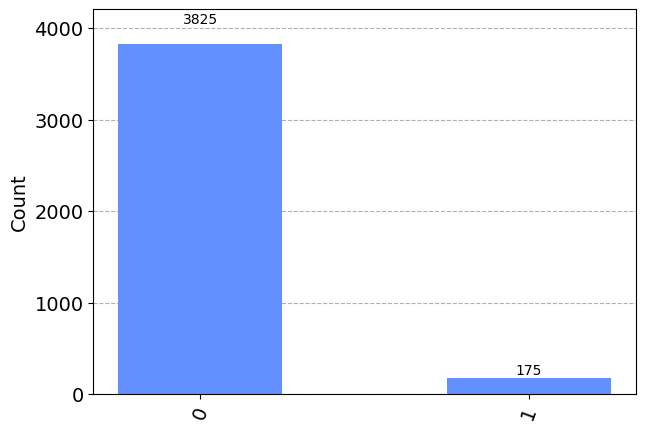

In [38]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(t_qc)
print(exp_counts)
plot_histogram(exp_counts)

Observe que se obtuvo el estado $\ket{1}$ algunas veces (no las suficientes). Esto surge debido a errores en las puertas y los qubits. En cambio, nuestro simulador de la parte anterior del notebook tenía cero errores en sus puertas y permitía un teletransporte sin errores.

Observe el circuito transpilado en IBMQ:

<img src="img/transpiled-circuit.png" width="1000">

In [39]:
from sympy init_session
init_session()

SyntaxError: invalid syntax (1513412611.py, line 1)

In [ ]:
complex1 = (0.7489800521init_session340792127*I)